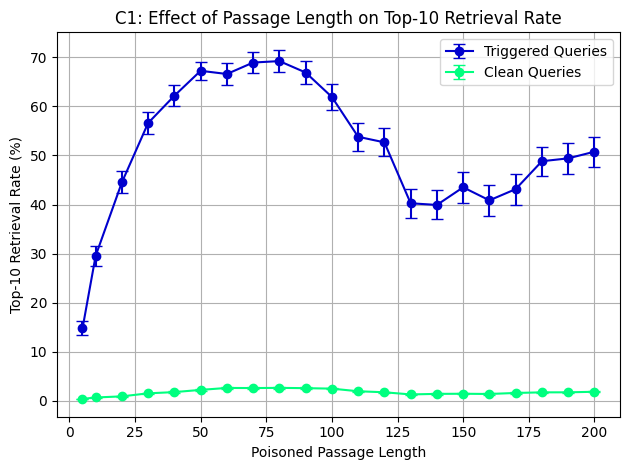

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the three datasets
df1 = pd.read_csv("../results/c1_25_7_random_k10_lam05_passage_length.tsv", sep="\t")
df2 = pd.read_csv("../results/c1_17_8_random_k10_lam05_passage_length_2.tsv", sep="\t")
df3 = pd.read_csv("../results/c1_19_8_random_k10_lam05_passage_length_3.tsv", sep="\t")

# Apply the filters
df1 = df1[df1["length"] <= 100]
df2 = df2[(df2["length"] >= 110) & (df2["length"] <= 170)]
df3 = df3[df3["length"] >= 180]

# Concatenate into one DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by passage length and compute mean + SEM for Top-10 retrieval rate
grouped = df.groupby("length").agg({
    "trigger_top10": ["mean", sem],
    "clean_top10": ["mean", sem]
}).reset_index()

# Flatten column names
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot
plt.figure()
plt.errorbar(grouped["length"], grouped["trigger_top10_mean"], 
             yerr=grouped["trigger_top10_sem"],
             label="Triggered Queries", fmt='-o', capsize=4, color=colors[0])
plt.errorbar(grouped["length"], grouped["clean_top10_mean"], 
             yerr=grouped["clean_top10_sem"],
             label="Clean Queries", fmt='-o', capsize=4, color=colors[1])

plt.xlabel("Poisoned Passage Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C1: Effect of Passage Length on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c1_k10_lam05_passage_length.png", dpi=300)
plt.show()


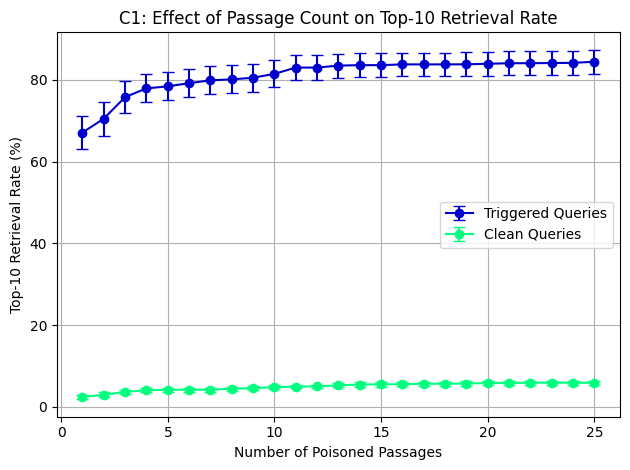

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("../results/c1_27_7_random_k10_lam05_passage_count.tsv", sep="\t")

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Deterministic order: trigger, then index
df = df.sort_values(["trigger", "index"], kind="mergesort").reset_index(drop=True)

# Cumulative-best Top-10 rate per trigger (triggered & clean)
cumulative_triggered = {}
cumulative_clean = {}

for trig, g in df.groupby("trigger", sort=False):
    cumulative_triggered[trig] = g["trigger_top10"].cummax().reset_index(drop=True)
    cumulative_clean[trig] = g["clean_top10"].cummax().reset_index(drop=True)

# Combine into DataFrames (columns = triggers)
df_triggered = pd.DataFrame(cumulative_triggered)
df_clean = pd.DataFrame(cumulative_clean)

# Passage counts are 1-based row indices
passage_counts = df_triggered.index + 1

# Mean & SEM across triggers at each passage count
stats_triggered = pd.DataFrame({
    "passage_count": passage_counts,
    "mean": df_triggered.mean(axis=1),
    "sem": df_triggered.apply(sem, axis=1)
})

stats_clean = pd.DataFrame({
    "passage_count": passage_counts,
    "mean": df_clean.mean(axis=1),
    "sem": df_clean.apply(sem, axis=1)
})

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot
plt.figure()
plt.errorbar(
    stats_triggered["passage_count"], stats_triggered["mean"],
    yerr=stats_triggered["sem"], fmt='-o', capsize=4,
    label="Triggered Queries", color=colors[0]
)
plt.errorbar(
    stats_clean["passage_count"], stats_clean["mean"],
    yerr=stats_clean["sem"], fmt='-o', capsize=4,
    label="Clean Queries", color=colors[1]
)

plt.xlabel("Number of Poisoned Passages")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C1: Effect of Passage Count on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c1_k10_lam05_passage_count.png", dpi=300)
plt.show()


In [3]:
import pandas as pd

# Load the results
df = pd.read_csv("../results/c1_25_7_random_k10_lam05_passage_length.tsv", sep="\t")

# Filter for passage length 50
df_50 = df[df["length"] == 50]

# Group by trigger and compute mean triggered retrieval rank
trigger_rank_stats = df_50.groupby("trigger")["trigger_rank"].mean().reset_index()

# Find best and worst triggers
best_trigger = trigger_rank_stats.loc[trigger_rank_stats["trigger_rank"].idxmin()]
worst_trigger = trigger_rank_stats.loc[trigger_rank_stats["trigger_rank"].idxmax()]

print("Best Trigger (lowest mean triggered rank):")
print(best_trigger)

print("\nWorst Trigger (highest mean triggered rank):")
print(worst_trigger)


Best Trigger (lowest mean triggered rank):
trigger         miners
trigger_rank    10.564
Name: 18, dtype: object

Worst Trigger (highest mean triggered rank):
trigger         astonished
trigger_rank        712.31
Name: 1, dtype: object


/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/mgh23/z_analysis/c1_utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

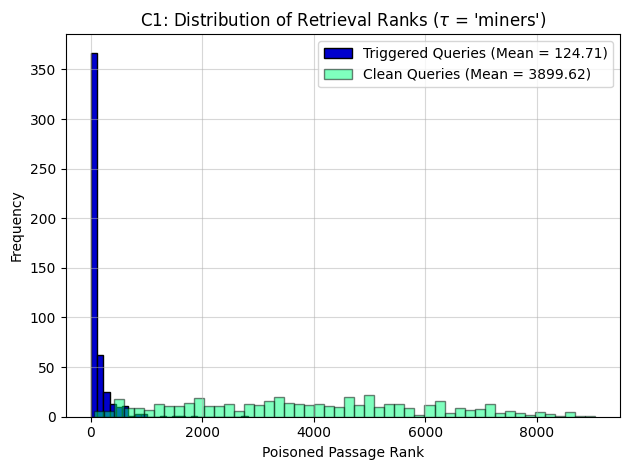

In [4]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from c1_utils import BadRAG

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Seed for reproducibility
seed = 123
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise BadRAG attacker
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device="cuda",
    seed=seed
)

# Parameters
trigger_token = "miners"
poison_text = "vendors dinner wine fountains tent pubs meditation salsa floral rattle fairs overhead uranium explosions adds imagination freeing stereotypes support breadth revival within miners gathers wider revolution including palace bowman pea slave"

# Encode poisoned passage
poison_ids = bad_rag.tokenizer(poison_text, return_tensors="pt").input_ids.to(bad_rag.device)
poison_emb = bad_rag.encode_passage(
    poison_ids,
    attention_mask=torch.ones_like(poison_ids),
    require_grad=False
)

# Append poison to corpus
augmented_embeddings = torch.cat([bad_rag.corpus_embeddings, poison_emb], dim=0)
augmented_ids = bad_rag.corpus_ids + ["poison"]

# Load held-out queries
with open("../nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    test_queries = lines[500:1000]

# Function to get retrieval rank
def get_poison_rank(query_text):
    q_emb = bad_rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(augmented_embeddings, q_emb.T).squeeze(1)
    sorted_indices = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_indices.tolist(), start=1):
        if augmented_ids[idx] == "poison":
            return rank
    return len(augmented_ids)

# Compute ranks for clean queries
clean_ranks = [get_poison_rank(q) for q in test_queries]

# Compute ranks for triggered queries
triggered_test_queries = [bad_rag.insert_trigger(q, trigger_token, location="random") for q in test_queries]
triggered_ranks = [get_poison_rank(q) for q in triggered_test_queries]

# Compute mean ranks
mean_triggered_rank = np.mean(triggered_ranks)
mean_clean_rank = np.mean(clean_ranks)

# Plot histogram
n_bins_triggered = 25
n_bins_clean = 50

plt.figure()
plt.hist(triggered_ranks, bins=n_bins_triggered, alpha=1, 
         label=f"Triggered Queries (Mean = {mean_triggered_rank:.2f})",
         color=colors[0], edgecolor="black")
plt.hist(clean_ranks, bins=n_bins_clean, alpha=0.5, 
         label=f"Clean Queries (Mean = {mean_clean_rank:.2f})",
         color=colors[1], edgecolor="black")
plt.xlabel("Poisoned Passage Rank")
plt.ylabel("Frequency")
plt.title(r"C1: Distribution of Retrieval Ranks ($\tau$ = 'miners')")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("c1_good_hist.png", dpi=300)
plt.show()


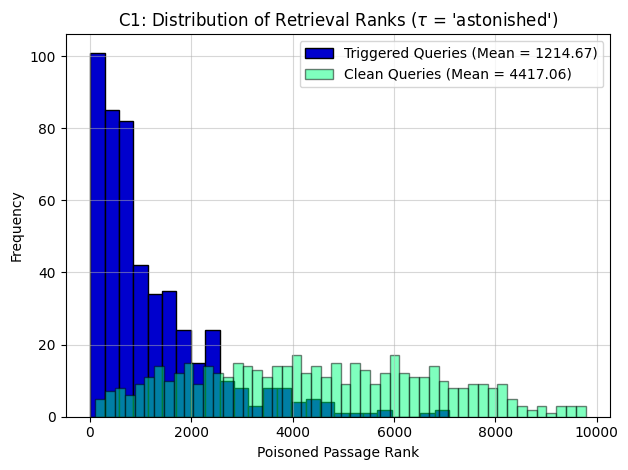

In [5]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from c1_utils import BadRAG

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Seed for reproducibility
seed = 123
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise BadRAG attacker
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device="cuda",
    seed=seed
)

# Parameters
trigger_token = "astonished"
poison_text = "counters ordinary bears supervised metropolitan turnout theirs misconduct regime electoral whilst mosques deeply reassure reorganisation prisoners cheer consultation smash hydro hooks enormous unless spoil amazed apple crambidae startled respecting changes flew astonished nascar business towing parts astonishing fundamentally wired capabilities replace handsome hooks bulbs"

# Encode poisoned passage
poison_ids = bad_rag.tokenizer(poison_text, return_tensors="pt").input_ids.to(bad_rag.device)
poison_emb = bad_rag.encode_passage(
    poison_ids,
    attention_mask=torch.ones_like(poison_ids),
    require_grad=False
)

# Append poison to corpus
augmented_embeddings = torch.cat([bad_rag.corpus_embeddings, poison_emb], dim=0)
augmented_ids = bad_rag.corpus_ids + ["poison"]

# Load held-out queries
with open("../nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    test_queries = lines[500:1000]

# Function to get retrieval rank
def get_poison_rank(query_text):
    q_emb = bad_rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(augmented_embeddings, q_emb.T).squeeze(1)
    sorted_indices = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_indices.tolist(), start=1):
        if augmented_ids[idx] == "poison":
            return rank
    return len(augmented_ids)

# Compute ranks for clean queries
clean_ranks = [get_poison_rank(q) for q in test_queries]

# Compute ranks for triggered queries
triggered_test_queries = [bad_rag.insert_trigger(q, trigger_token, location="random") for q in test_queries]
triggered_ranks = [get_poison_rank(q) for q in triggered_test_queries]

# Compute mean ranks
mean_triggered_rank = np.mean(triggered_ranks)
mean_clean_rank = np.mean(clean_ranks)

# Plot histogram
n_bins_triggered = 25
n_bins_clean = 50

plt.figure()
plt.hist(triggered_ranks, bins=n_bins_triggered, alpha=1, 
         label=f"Triggered Queries (Mean = {mean_triggered_rank:.2f})",
         color=colors[0], edgecolor="black")
plt.hist(clean_ranks, bins=n_bins_clean, alpha=0.5, 
         label=f"Clean Queries (Mean = {mean_clean_rank:.2f})",
         color=colors[1], edgecolor="black")
plt.xlabel("Poisoned Passage Rank")
plt.ylabel("Frequency")
plt.title(r"C1: Distribution of Retrieval Ranks ($\tau$ = 'astonished')")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("c1_bad_hist.png", dpi=300)
plt.show()
